In [1]:
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
import pandas as pd

from time import time

import matplotlib.pyplot as plt

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras.__version__, tf.__version__, np.__version__

('2.1.5', '1.6.0', '1.14.2')

In [3]:
data = pd.read_csv("/data/airline-passengers.csv", skiprows=1
                , skipfooter=4, names=["date", "passenger_count"], engine="python").passenger_count.values
data

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390])

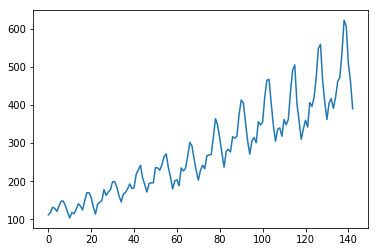

In [4]:
plt.plot(data)

In [5]:
pd.Series(data).describe()

count    143.000000
mean     279.237762
std      119.708270
min      104.000000
25%      180.000000
50%      264.000000
75%      359.500000
max      622.000000
dtype: float64

In [6]:
data_scaled = (data - np.min(data)) / (np.max(data) - np.min(data))
data_scaled

array([0.01544402, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
       0.05984556, 0.08494208, 0.08494208, 0.06177606, 0.02895753,
       0.        , 0.02702703, 0.02123552, 0.04247104, 0.07142857,
       0.05984556, 0.04054054, 0.08687259, 0.12741313, 0.12741313,
       0.1042471 , 0.05598456, 0.01930502, 0.06949807, 0.07915058,
       0.08880309, 0.14285714, 0.11389961, 0.13127413, 0.14285714,
       0.18339768, 0.18339768, 0.15444015, 0.11196911, 0.08108108,
       0.11969112, 0.12934363, 0.14671815, 0.17181467, 0.14864865,
       0.15250965, 0.22007722, 0.24324324, 0.26640927, 0.2027027 ,
       0.16795367, 0.13127413, 0.17374517, 0.17760618, 0.17760618,
       0.25482625, 0.25289575, 0.24131274, 0.26833977, 0.30888031,
       0.32432432, 0.25675676, 0.20656371, 0.14671815, 0.18725869,
       0.19305019, 0.16216216, 0.25289575, 0.23745174, 0.25096525,
       0.30888031, 0.38223938, 0.36486486, 0.2992278 , 0.24131274,
       0.19111969, 0.24131274, 0.26640927, 0.24903475, 0.31467

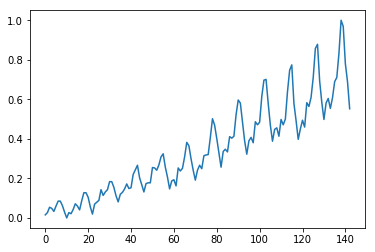

In [7]:
plt.plot(data_scaled)

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [9]:
training_size = int(len(data) * 0.7)

In [10]:
training = data_scaled[:training_size]
testing = data_scaled[training_size: ]

In [11]:
def create_sequences(data, sequence_len, step = 1):
    data_len = len(data)
    X = []
    y = []
    for start in range(0, data_len - sequence_len, step):
        end = start + sequence_len
        sequence = data[start: end]
        X.append(sequence)
        y.append(data[end])
    return np.array(X), np.array(y)


In [12]:
X, y = create_sequences(data_scaled, sequence_len= 5)
df = pd.DataFrame(X, columns=["x%d" % i for i in range(X.shape[1])])
df["y"] = y
df.head()

,x0,x1,x2,x3,x4,y
0,0.015444,0.027027,0.054054,0.048263,0.032819,0.059846
1,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942
2,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942
3,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776
4,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958


In [13]:
def show_values(y_train, y_test, y_train_pred, y_test_pred):
    y_train_pred = y_train_pred.flatten()
    y_test_pred = y_test_pred.flatten()
    plt.plot(np.append(y_train, y_test), color = "lightblue", label = "Actual")
    plt.plot(range(0, len(y_train_pred)), y_train_pred, color="orange", label = "Prediction - train")
    plt.plot(range(len(y_train_pred), len(y_train_pred) + len(y_test_pred)), y_test_pred, color="red", label = "Prediction - test")
    plt.legend()
    train_rmse = rmse(y_train, y_train_pred)
    test_rmse = rmse(y_test, y_test_pred)
    plt.title("RMSE (train: %f, test: %f)" % (train_rmse, test_rmse))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
99/99 [==============================] - 1s 6ms/step - loss: 0.0460
Epoch 2/100
99/99 [==============================] - 0s 4ms/step - loss: 0.0209
Epoch 3/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 4/100
99/99 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 5/100
99/99 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 6/100
99/99 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 7/100
99/99 [==============================] - 0s 5ms/

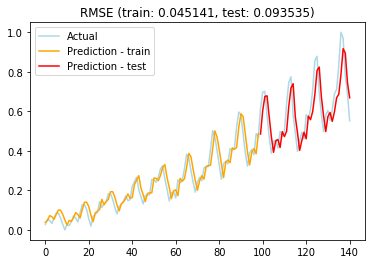

In [14]:
sequence_len = 1
X_train, y_train = create_sequences(training, sequence_len)
X_test, y_test = create_sequences(testing, sequence_len)

model = Sequential()
model.add(LSTM(4, activation="tanh", input_shape=(sequence_len, 1)))
model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

tensor_board = TensorBoard(log_dir="/tmp/tf/logs/%d" % time())
model.fit(X_train.reshape(-1, sequence_len, 1), y_train
          , epochs=100
          , batch_size=1
          , verbose=1
          , callbacks=[tensor_board])

y_train_pred = model.predict(X_train.reshape(-1, sequence_len, 1))
y_test_pred = model.predict(X_test.reshape(-1, sequence_len, 1))
show_values(y_train, y_test, y_train_pred, y_test_pred)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
97/97 [==============================] - 1s 7ms/step - loss: 0.0265
Epoch 2/100
97/97 [==============================] - 1s 6ms/step - loss: 0.0111
Epoch 3/100
97/97 [==============================] - 1s 6ms/step - loss: 0.0094
Epoch 4/100
97/97 [==============================] - 0s 5ms/step - loss: 0.0079
Epoch 5/100
97/97 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 6/100
97/97 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 7/100
97/97 [==============================] - 1s 6ms/

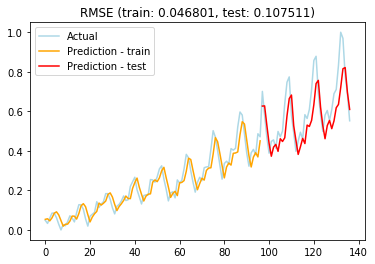

In [15]:
tf.set_random_seed(1)
np.random.seed(1)

sequence_len = 3
X_train, y_train = create_sequences(training, sequence_len)
X_test, y_test = create_sequences(testing, sequence_len)

model = Sequential()
model.add(LSTM(4, activation="tanh", input_shape=(sequence_len, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

tensor_board = TensorBoard(log_dir="/tmp/tf/logs/%d" % time())
model.fit(X_train.reshape(-1, sequence_len, 1), y_train
          , epochs=100
          , batch_size=1
          , verbose=1
          , callbacks=[tensor_board])

y_train_pred = model.predict(X_train.reshape(-1, sequence_len, 1))
y_test_pred = model.predict(X_test.reshape(-1, sequence_len, 1))

show_values(y_train, y_test, y_train_pred, y_test_pred)

# Stateful and stacked with time step and window

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 3, 4)                 96        
_________________________________________________________________
dropout_1 (Dropout)          (1, 3, 4)                 0         
_________________________________________________________________
lstm_4 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1
97/97 [==============================] - 1s 10ms/step - loss: 0.0055
Epoch 1/1
97/97 [==============================] - 1s 5ms/step - loss: 0.0153
Epoch 1/1
97/97 [==============================] - 1s 6ms/step - loss: 0.0124
Epoch 1/1
97/97 [========================

97/97 [==============================] - 1s 5ms/step - loss: 0.0046
Epoch 1/1
97/97 [==============================] - 1s 6ms/step - loss: 0.0059
Epoch 1/1
97/97 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 1/1
97/97 [==============================] - 1s 5ms/step - loss: 0.0049
Epoch 1/1
97/97 [==============================] - 1s 5ms/step - loss: 0.0048
Epoch 1/1
97/97 [==============================] - 1s 6ms/step - loss: 0.0046


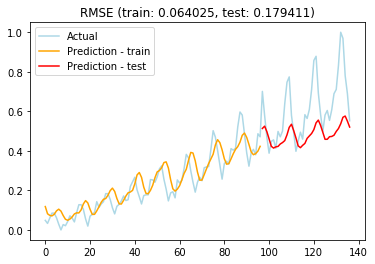

In [16]:
tf.set_random_seed(1)
np.random.seed(1)

sequence_len = 3
X_train, y_train = create_sequences(training, sequence_len)
X_test, y_test = create_sequences(testing, sequence_len)

model = Sequential()
model.add(LSTM(4, batch_input_shape = (1, sequence_len, 1)
               , input_shape=(sequence_len, 1), stateful=True, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(4, input_shape=(sequence_len, 1)))
model.add(Dense(1, activation = None))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

tensor_board = TensorBoard(log_dir="/tmp/tf/logs/%d" % time())
for i in range(100):
    model.fit(X_train.reshape(-1, sequence_len, 1), y_train 
              , epochs=1
              , batch_size=1
              , verbose=1
              , shuffle=False
              , callbacks=[tensor_board])
    model.reset_states()

y_train_pred = model.predict(X_train.reshape(-1, sequence_len, 1), batch_size=1)
y_test_pred = model.predict(X_test.reshape(-1, sequence_len, 1), batch_size=1)

show_values(y_train, y_test, y_train_pred, y_test_pred)